In [1]:
import numpy as np
import os, shutil
import time
import matplotlib.pyplot as plt


from keras.models import load_model

import torchsummary

import torch.nn.functional as F


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

C:\Users\axele\anaconda3\envs\MLDL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation des données et fonction fit

In [2]:
#Chargement du jeu de données
original_dataset_dir = r'C:\Users\axele\OneDrive\Documents\Projet_MLDL'

train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))


############################################################################################################

#Definir la fonction de transformation
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Définir le jeu de données d'entraînement
train_dataset = ImageFolder(original_dataset_dir + '/train_another', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

# Définir le jeu de données de validation
val_dataset = ImageFolder(original_dataset_dir + '/validation_another', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)


total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [3]:
# fonction pour entrainer les modeles
def fit(model, criterion, optimizer, train_loader, val_loader, epochs, steps_per_epoch, validation_steps):
    epoch_nums = []
    training_acc = []
    validation_acc = []
    training_loss = []
    validation_loss = []
    
    for epoch in range(epochs):
        accuracy = 0.0
        running_loss = 0.0
        start_time = time.time()
        # Entraîne le modèle sur les données d'entraînement
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Entraîne le modèle sur un lot de données
            outputs = model(images)
            loss = criterion(outputs, labels.float().view(-1,1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            accuracy += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
            running_loss += loss.item()
        
            if (i+1) % steps_per_epoch == 0:
                break
        train_loss = running_loss / steps_per_epoch
        train_acc = accuracy / steps_per_epoch 
                
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            for i, (images, labels) in enumerate(val_loader):
                outputs = model(images)
                val_loss += criterion(outputs, labels.float().view(-1,1)).item()
                _, predicted = torch.max(outputs.data, 1)
                val_acc += (torch.round(outputs) == labels.float().view(-1,1)).sum().item() / len(labels)
                
                if i >= validation_steps:
                    break
        
        val_loss /= validation_steps
        val_acc /= validation_steps 

        epoch_nums.append(epoch+1)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_acc.append(train_acc)
        validation_acc.append(val_acc)
        
        elapsed_time = time.time() - start_time
        print(elapsed_time)
        print(f"Epoch [{epoch+1}/{epochs}], Time : {elapsed_time:.4f}, Train Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        
    return {
        'training_acc': training_acc,
        'validation_acc': validation_acc,
        'training_loss': training_loss,
        'validation_loss': validation_loss
    }

def params_to_update(model) :
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
    return params_to_update

## Avec le modèle pré-entrainé resnet18


In [4]:
class ResNet18Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=True)
        self.model.fc = nn.Linear(512, 1)

    def forward(self, x):
        x = self.model(x)
        x = nn.Sigmoid()(x)
        return x

model1 = ResNet18Sigmoid()

#torchsummary.summary(model1, (3,150,150))

C:\Users\axele\anaconda3\envs\MLDL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
#Resnet18 avec l'optimizer RMSProp
#train_losses1, val_accuracies1, val_losses1 = train_model(optimizer1, criterion, model1, val_loader, train_loader)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(params_to_update(model1), lr=0.001)
history = fit(model1, criterion, optimizer, train_loader, val_loader, 25, 100, 50 )

78.39934015274048
Epoch [1/25], Time : 78.3993, Train Loss: 0.2659, Train Accuracy: 0.8135, Validation Loss: 0.8551, Validation Accuracy: 0.7000
59.35649228096008
Epoch [2/25], Time : 59.3565, Train Loss: 0.2734, Train Accuracy: 0.8940, Validation Loss: 0.3101, Validation Accuracy: 0.9230
58.77400994300842
Epoch [3/25], Time : 58.7740, Train Loss: 0.0232, Train Accuracy: 0.9130, Validation Loss: 1.5871, Validation Accuracy: 0.6050
58.69100069999695
Epoch [4/25], Time : 58.6910, Train Loss: 0.1315, Train Accuracy: 0.9170, Validation Loss: 0.1739, Validation Accuracy: 0.9590
58.79300117492676
Epoch [5/25], Time : 58.7930, Train Loss: 0.3024, Train Accuracy: 0.9225, Validation Loss: 0.3790, Validation Accuracy: 0.8890
58.77799844741821
Epoch [6/25], Time : 58.7780, Train Loss: 0.0858, Train Accuracy: 0.9310, Validation Loss: 30.7426, Validation Accuracy: 0.5190
58.94483542442322
Epoch [7/25], Time : 58.9448, Train Loss: 0.0599, Train Accuracy: 0.9390, Validation Loss: 0.1789, Validation A

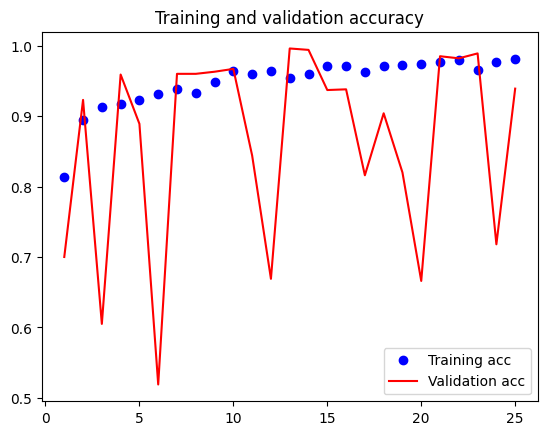

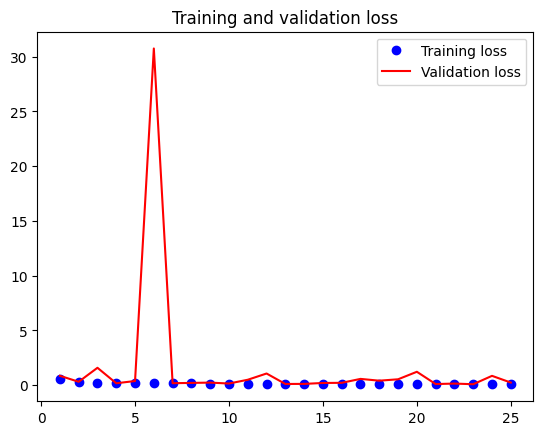

In [6]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
#Resnet18 avec l'optimizer Adam
criterion = nn.BCELoss()
optimizer = optim.Adam(params_to_update(model1), lr=0.001)
history = fit(model1, criterion, optimizer, train_loader, val_loader, 25, 100, 50 )

60.362998247146606
Epoch [1/25], Time : 60.3630, Train Loss: 0.0278, Train Accuracy: 0.9780, Validation Loss: 0.3240, Validation Accuracy: 0.8850
60.1850004196167
Epoch [2/25], Time : 60.1850, Train Loss: 0.1056, Train Accuracy: 0.9780, Validation Loss: 0.1466, Validation Accuracy: 0.9660
60.328999280929565
Epoch [3/25], Time : 60.3290, Train Loss: 0.0342, Train Accuracy: 0.9800, Validation Loss: 0.0672, Validation Accuracy: 0.9970
60.25600337982178
Epoch [4/25], Time : 60.2560, Train Loss: 0.0786, Train Accuracy: 0.9800, Validation Loss: 0.0870, Validation Accuracy: 0.9870
60.401997327804565
Epoch [5/25], Time : 60.4020, Train Loss: 0.0047, Train Accuracy: 0.9830, Validation Loss: 1.0647, Validation Accuracy: 0.7390
60.29899978637695
Epoch [6/25], Time : 60.2990, Train Loss: 0.0101, Train Accuracy: 0.9860, Validation Loss: 1.7474, Validation Accuracy: 0.5990
60.40999960899353
Epoch [7/25], Time : 60.4100, Train Loss: 0.0071, Train Accuracy: 0.9785, Validation Loss: 0.4706, Validation 

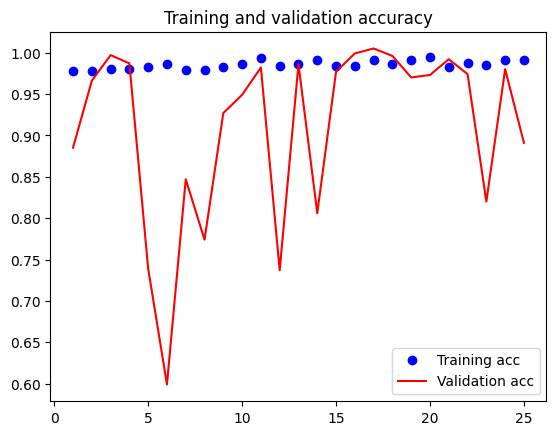

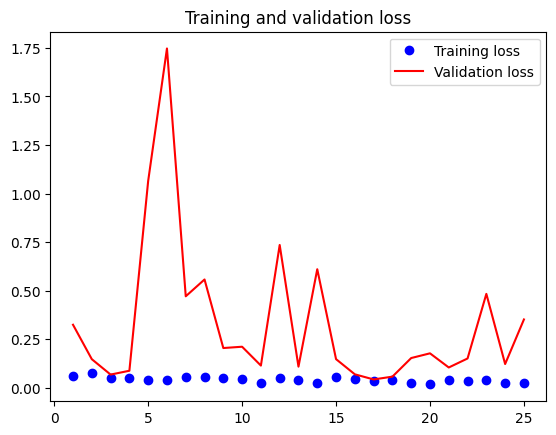

In [8]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

 ### Modification de plusieurs couches de ResNet18
 

In [9]:
class ResNet18Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=True)
        #num_features = self.model.fc.in_features
        self.fc = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = F.relu(self.fc(x))
        x = F.relu(self.fc2(x))        
        x = self.sigmoid(x)
        return x

model1 = ResNet18Sigmoid()



In [10]:
#Resnet18  modifié avec l'optimizer Adam
criterion = nn.BCELoss()
optimizer = optim.Adam(params_to_update(model1), lr=0.001)
history = fit(model1, criterion, optimizer, train_loader, val_loader, 25, 100, 50 )

60.79000520706177
Epoch [1/25], Time : 60.7900, Train Loss: 0.6931, Train Accuracy: 0.5355, Validation Loss: 0.7070, Validation Accuracy: 0.5130
60.97599768638611
Epoch [2/25], Time : 60.9760, Train Loss: 0.6931, Train Accuracy: 0.5020, Validation Loss: 0.7070, Validation Accuracy: 0.5290
60.90899705886841
Epoch [3/25], Time : 60.9090, Train Loss: 0.6931, Train Accuracy: 0.5080, Validation Loss: 0.7070, Validation Accuracy: 0.4990
60.878997802734375
Epoch [4/25], Time : 60.8790, Train Loss: 0.6931, Train Accuracy: 0.5010, Validation Loss: 0.7070, Validation Accuracy: 0.5210
60.96600008010864
Epoch [5/25], Time : 60.9660, Train Loss: 0.6931, Train Accuracy: 0.4940, Validation Loss: 0.7070, Validation Accuracy: 0.5170
60.91099977493286
Epoch [6/25], Time : 60.9110, Train Loss: 0.6931, Train Accuracy: 0.4965, Validation Loss: 0.7070, Validation Accuracy: 0.5160
60.90600252151489
Epoch [7/25], Time : 60.9060, Train Loss: 0.6931, Train Accuracy: 0.5170, Validation Loss: 0.7070, Validation A

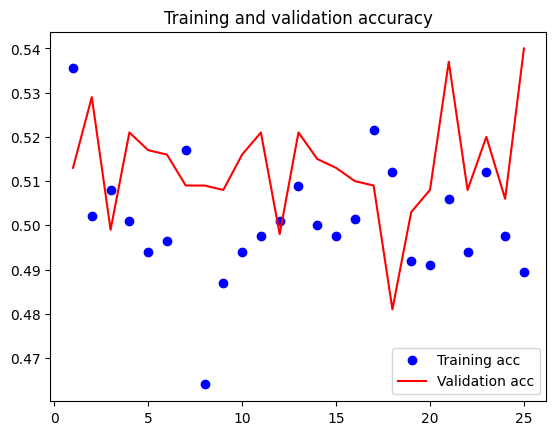

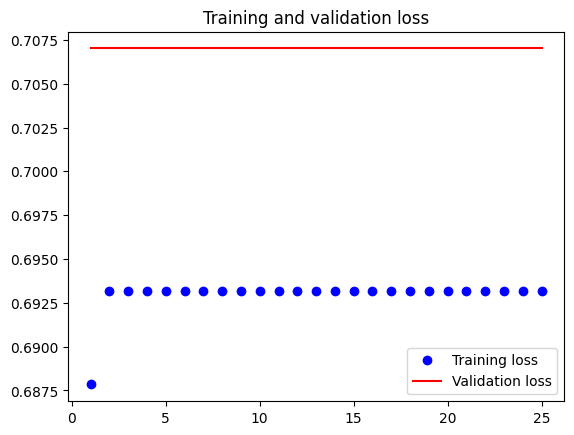

In [11]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Avec le modèle pré-entrainé AlexNet

In [18]:
class AlexNetSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.alexnet(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

model2 = AlexNetSigmoid()


C:\Users\axele\anaconda3\envs\MLDL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\axele\anaconda3\envs\MLDL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\axele/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [02:25<00:00, 1.68MB/s]


In [19]:
#AlexNet avec l'optimizer Adam
criterion = nn.BCELoss()
optimizer = optim.Adam(params_to_update(model2), lr=0.001)
history = fit(model2, criterion, optimizer, train_loader, val_loader, 15, 100, 50 )

46.82912611961365
Epoch [1/15], Time : 46.8291, Train Loss: 0.3913, Train Accuracy: 0.7055, Validation Loss: 0.5759, Validation Accuracy: 0.8720
46.35289120674133
Epoch [2/15], Time : 46.3529, Train Loss: 0.2450, Train Accuracy: 0.8555, Validation Loss: 0.1880, Validation Accuracy: 0.9400
46.389103174209595
Epoch [3/15], Time : 46.3891, Train Loss: 0.4183, Train Accuracy: 0.8325, Validation Loss: 0.5157, Validation Accuracy: 0.9210
46.35636830329895
Epoch [4/15], Time : 46.3564, Train Loss: 0.1764, Train Accuracy: 0.8685, Validation Loss: 0.2072, Validation Accuracy: 0.9370
46.27757501602173
Epoch [5/15], Time : 46.2776, Train Loss: 0.2329, Train Accuracy: 0.8820, Validation Loss: 0.2556, Validation Accuracy: 0.9340
46.29057288169861
Epoch [6/15], Time : 46.2906, Train Loss: 0.5322, Train Accuracy: 0.8760, Validation Loss: 0.5731, Validation Accuracy: 0.9060
46.69971418380737
Epoch [7/15], Time : 46.6997, Train Loss: 0.6930, Train Accuracy: 0.6280, Validation Loss: 0.7052, Validation A

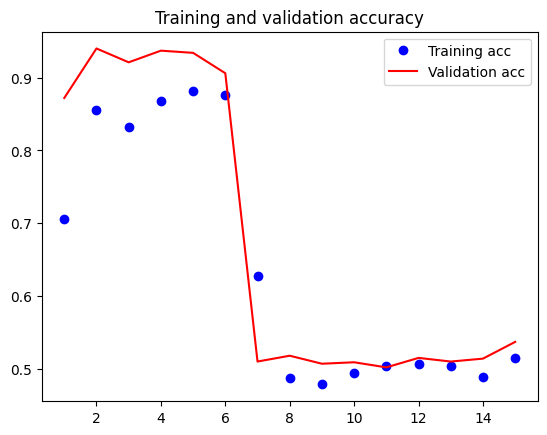

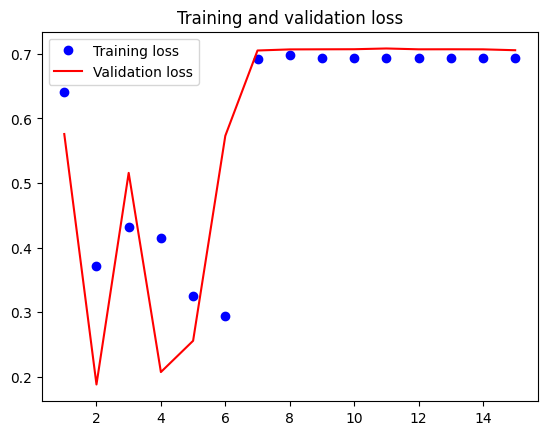

In [20]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Avec le modèle pré-entrainé VGG16

In [15]:
class VGG16Sigmoid(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.model = torchvision.models.vgg16(weights=True)
        self.model.classifier[6] = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

model3 = VGG16Sigmoid()


C:\Users\axele\anaconda3\envs\MLDL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\axele/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [07:46<00:00, 1.19MB/s]


In [16]:
#VGG16 avec l'optimizer Adam
criterion = nn.BCELoss()
optimizer = optim.Adam(params_to_update(model3), lr=0.001)
history = fit(model3, criterion, optimizer, train_loader, val_loader, 25, 100, 50 )

356.0608432292938
Epoch [1/25], Time : 356.0608, Train Loss: 0.6388, Train Accuracy: 0.5655, Validation Loss: 0.6649, Validation Accuracy: 0.5870
357.58615922927856
Epoch [2/25], Time : 357.5862, Train Loss: 0.6584, Train Accuracy: 0.8155, Validation Loss: 0.2433, Validation Accuracy: 0.9390
372.5235812664032
Epoch [3/25], Time : 372.5236, Train Loss: 0.0677, Train Accuracy: 0.8950, Validation Loss: 0.3380, Validation Accuracy: 0.9490
366.2533814907074
Epoch [4/25], Time : 366.2534, Train Loss: 0.0627, Train Accuracy: 0.9180, Validation Loss: 0.1680, Validation Accuracy: 0.9390
369.8476119041443
Epoch [5/25], Time : 369.8476, Train Loss: 0.2067, Train Accuracy: 0.9155, Validation Loss: 0.1714, Validation Accuracy: 0.9550
371.87588572502136
Epoch [6/25], Time : 371.8759, Train Loss: 0.1853, Train Accuracy: 0.9185, Validation Loss: 0.3252, Validation Accuracy: 0.9530
371.44892954826355
Epoch [7/25], Time : 371.4489, Train Loss: 0.2379, Train Accuracy: 0.8505, Validation Loss: 0.2678, Val

KeyboardInterrupt: 

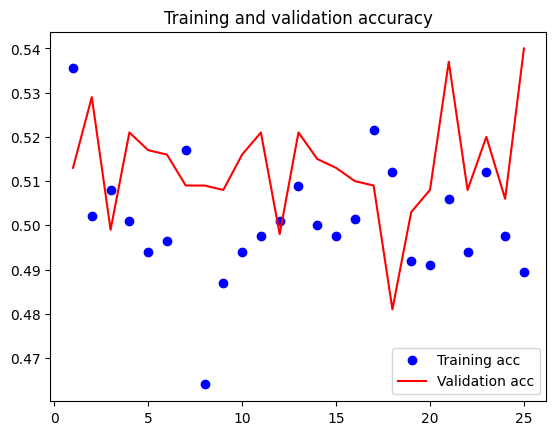

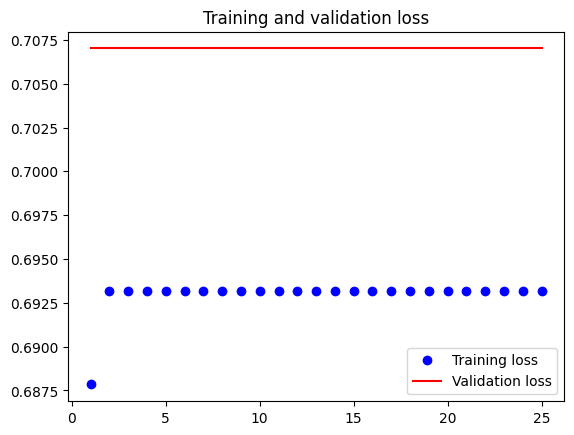

In [17]:
training_acc = history['training_acc']
validation_acc = history['validation_acc']
training_loss = history['training_loss']
validation_loss = history['validation_loss']
epoch_nums = range(1,len(training_acc)+1)

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()